# Very simple notebook to get to a boosted tree regression model

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# get pandas
import pandas as pd
# we'll do some visual checks, get the necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [2]:
# get the input df
df_raw = pd.read_csv('../data/train.csv')

In [3]:
# wrapper function to perform some simple cleanup
def clean_df(df):
    # keep only certain variable types
    df = df.select_dtypes(include=['int64','float64'])
    # drop everything with more than 10% of missing values
    df = df[df.columns[df.isnull().mean() < 0.1]]
    # looks like Garage built goes with Year built, replace NA using that
    df.loc[df['GarageYrBlt'].isnull(),'GarageYrBlt'] = df['YearBuilt']
    # put zero for MasVnrArea
    df.loc[df['MasVnrArea'].isnull(),'MasVnrArea'] = 0.0
    # drop id
    df = df.drop(['Id'], axis=1)    
    # remove outliers
    df = df[df['GrLivArea'] < 4676] 
    return df

In [4]:
df = clean_df(df_raw)

In [9]:
# now we will look at the variable ranking with a different approach, GBT
from sklearn import ensemble
# prep scikit
input_features = list(df.columns)
input_features.remove('SalePrice')
X = df[input_features].values
y = np.log(df['SalePrice']+1).values

In [13]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

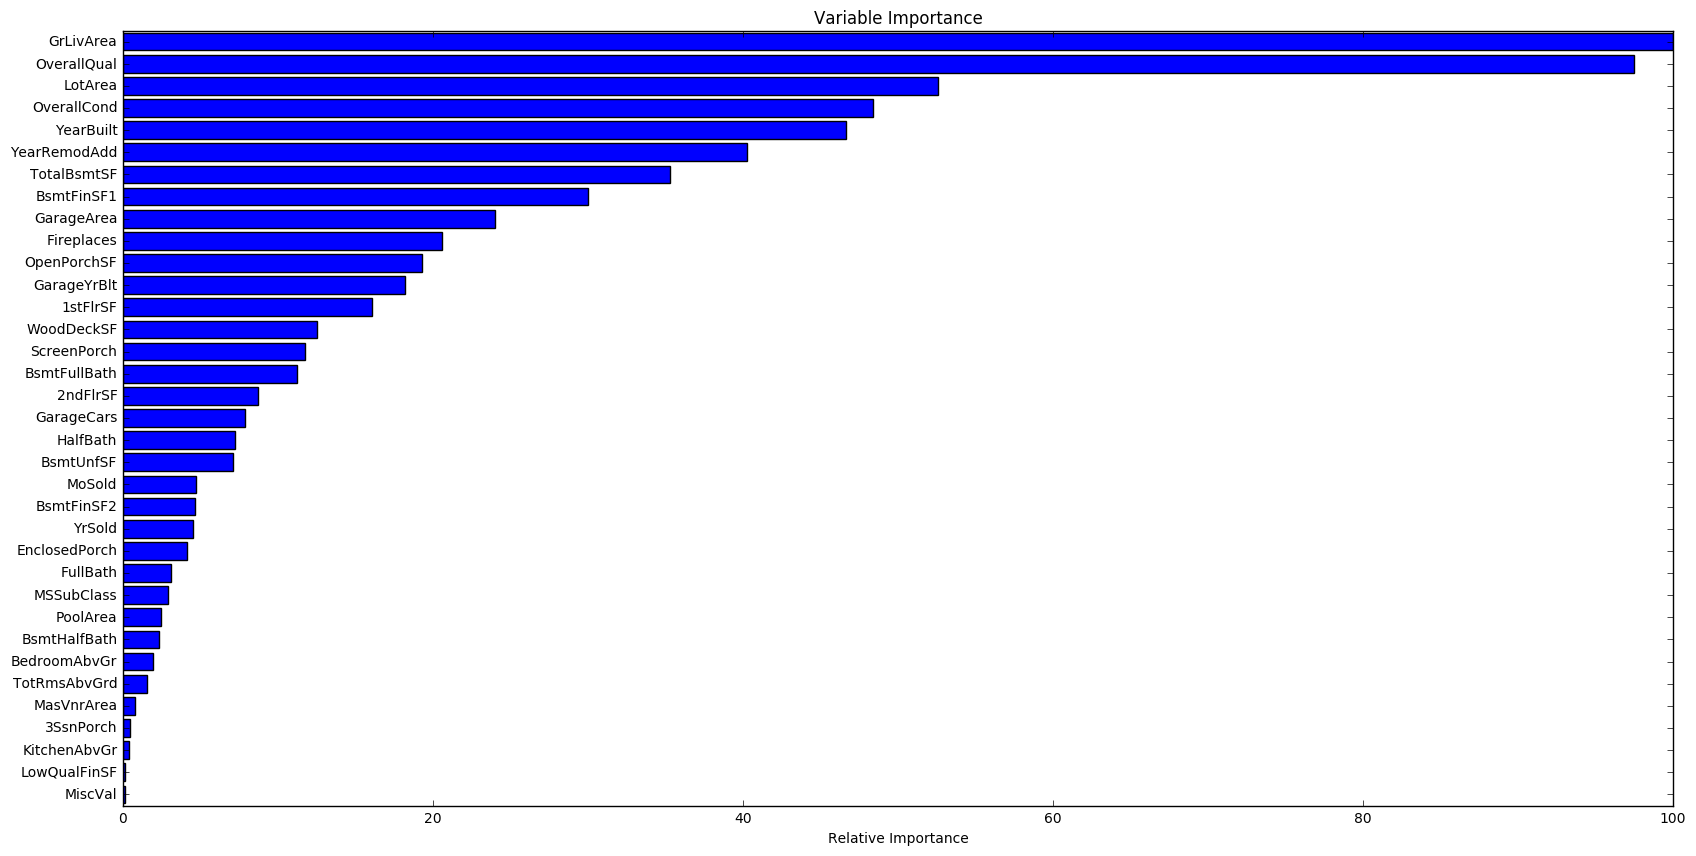

In [14]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, [input_features[i] for i in sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [15]:
# to have an idea of the score
from sklearn.model_selection import cross_val_score
# check model performance
scores = cross_val_score(clf, X, y, cv=3, scoring='neg_mean_squared_error')
# transform scores into the root mean square
scores = np.sqrt(-scores)
print("Mean Squared Error (on Log): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Mean Squared Error (on Log): 0.13 (+/- 0.01)


In [16]:
# looks good save the model
import pickle
pickle.dump(clf, open('../models/gbt_reg_v1.pkl', 'wb'))